### Install and import necessary packages

In [ ]:
!pip install transformers seqeval[gpu]
!pip install datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 10.2 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 120 kB 84.3 MB/s 
     |████████████████████████████████| 6.6 MB 62.4 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=ca6538ed387b58203d8eaf925401ad48edeb0fe44ab7255029e3842a7b44da98
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 6.6 MB/s 
     |████████████████████████████████| 212 kB 69.0 MB/s 
     |████████████████████████████████| 115 kB 87.3 MB/s 
     |████████████████████████████████| 127 kB 73.3 MB/s 
  Attempting uninstall: urllib3
    Found existing inst

In [ ]:
import torch
import datasets
from collections import Counter
from datasets import load_dataset
from datasets import Dataset
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd

In [ ]:
torch.cuda.is_available()
device = torch.device("cuda")

## Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
!ls '/content/drive/MyDrive/eth_CIL_exercise/data'
df_train = pd.read_csv('/content/drive/MyDrive/case-2022/data/ST1/train_subtask1.csv')
df_val = pd.read_csv('/content/drive/MyDrive/case-2022/data/ST1/dev_subtask1.csv')
df_test = pd.read_csv('/content/drive/MyDrive/case-2022/data/ST1/test_subtask1_text.csv')
df_test['label'] = 0
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)


Mounted at /content/drive
ls: cannot access '/content/drive/MyDrive/eth_CIL_exercise/data': No such file or directory
(2925, 6)
(323, 6)
(311, 3)


In [ ]:
df_val['num_votes'].unique()

array([6, 5, 4, 3])

In [ ]:
train_ds = Dataset.from_pandas(df_train)
val_ds = Dataset.from_pandas(df_val)
test_ds = Dataset.from_pandas(df_test)
train_ds[111] # Example of instance of the dataset

{'index': 'train_01_111',
 'text': 'They exhorted us to join the protest against the recommendations of the Mandal Commission , which had been implemented a day earlier .',
 'label': 0,
 'agreement': 0.666666667,
 'num_votes': 3,
 'sample_set': 'train_01'}

## Preprocessing - Data exploration

In [ ]:
# df_train['ce'] = df_train['agreement']
# df_train['non-ce'] = df_train['agreement']
for i in range(df_train.shape[0]): 
  if df_train['label'][i] == 1:
    df_train['ce'][i] = df_train['agreement'][i] 
    df_train['non-ce'][i] = (1 - df_train['agreement'][i])
  else:
    df_train['non-ce'][i] = df_train['agreement'][i]
    df_train['ce'][i] = (1 - df_train['agreement'][i])
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [ ]:
df_val['num_votes'].unique()

array([6, 5, 4, 3])

In [ ]:
df_train.head(6)

,index,text,label,agreement,num_votes,sample_set,ce,non-ce
0,train_01_0,The State alleged they hacked Sabata Petros Ch...,1,0.666667,3,train_01,0.666667,0.333333
1,train_01_1,Chale was allegedly chased by a group of about...,0,1.000000,3,train_01,0.000000,1.000000
2,train_01_2,His attackers allegedly drank his blood .,0,1.000000,3,train_01,0.000000,1.000000
3,train_01_3,Tip asked Mathunjwa why he had not `` explicit...,0,1.000000,3,train_01,0.000000,1.000000
4,train_01_4,`` It the protest was something which happened...,0,1.000000,3,train_01,0.000000,1.000000
5,train_01_5,"Police opened fire , killing 34 striking worke...",1,1.000000,3,train_01,1.000000,0.000000


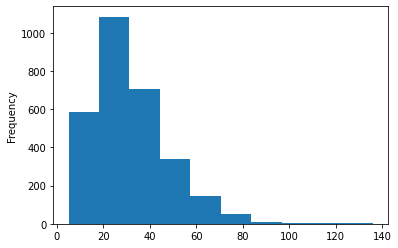

In [ ]:
# Get length of each datapoint from the train dataset #remember to do it for all trainset
length = []
for line in train_ds:
  length.append(len(line['text'].split()))
#histogram
df = pd.Series(length)
ax = df.plot.hist()


# Tokenizing data - Model name

**model_name**
- [x] model_name = 'bert-base-cased'


In [ ]:
# Load BERT/ROBERTA/XLNet tokenizer.
model_name = 'bert-base-cased'

In [ ]:
#tokenizer = XLNetTokenizer.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
#example: tokenizing one datapoint 
tokenizer(train_ds[7]['text'])

{'input_ids': [101, 8403, 118, 9518, 12971, 157, 1611, 3818, 1163, 1103, 10674, 3390, 1103, 12522, 1120, 1103, 9693, 2021, 1466, 1378, 170, 3922, 5361, 1468, 112, 5641, 1107, 1103, 1298, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:

def encode_dataset(dataset: datasets.arrow_dataset.Dataset) -> list:
  '''
  Transforming each instance of the dataset with the Tokenizer
  '''
  encoded_dataset = []
  for item in dataset:
    # Tokenize the sentence.
    sentence_encoded = tokenizer(item['text'],
                                return_tensors="pt", 
                                padding='max_length', 
                                truncation=True, 
                                max_length=60) 
    
    sentence_encoded['labels'] = torch.LongTensor(np.array([item['label']]))
    encoded_dataset.append(sentence_encoded)

  # Reduce dimensionality of tensors.
  for item in encoded_dataset:
    for key in item:
      item[key] = torch.squeeze(item[key])
  return encoded_dataset

In [ ]:
# Tokenizing datasets
encoded_dataset_train = encode_dataset(train_ds)
encoded_dataset_val = encode_dataset(val_ds)
encoded_dataset_test = encode_dataset(test_ds)

In [ ]:
# Example of dataset
for token, token_label in zip(tokenizer.convert_ids_to_tokens(encoded_dataset_train[50]["input_ids"]), encoded_dataset_train[50]["input_ids"]):
  print('{0:10}  {1}'.format(token, token_label))

[CLS]       101
Author      14593
##ities     4233
yesterday   8128
said        1163
they        1152
would       1156
scrap       16720
the         1103
10          1275
.           119
4           125
billion     3775
y           194
##uan       8734
(           113
HK          25660
$           109
12          1367
.           119
7           128
billion     3775
)           114
project     1933
,           117
the         1103
subject     2548
of          1104
demonstrations  14476
by          1118
tens        17265
of          1104
thousands   4674
of          1104
Shi         14104
##fan       16740
##g         1403
residents   3159
.           119
[SEP]       102
[PAD]       0
[PAD]       0
[PAD]       0
[PAD]       0
[PAD]       0
[PAD]       0
[PAD]       0
[PAD]       0
[PAD]       0
[PAD]       0
[PAD]       0
[PAD]       0
[PAD]       0
[PAD]       0
[PAD]       0
[PAD]       0
[PAD]       0
[PAD]       0
[PAD]       0
[PAD]       0


# Fine tunning of the model

In [ ]:
# Create dictionaries to transform from labels to id and vice-versa.
id2label = {0 : 'causualeffect',
            1 : 'non-causualeffect'}
label2id = {v:k for k,v in id2label.items()}
num_labels = len(id2label)
print(id2label)

{0: 'causualeffect', 1: 'non-causualeffect'}


In [ ]:
# Common training arguments
training_args = TrainingArguments(
    num_train_epochs=10,
    per_device_train_batch_size=512,
    per_device_eval_batch_size=512,
    logging_dir='logs',
    no_cuda=False,  
    output_dir = 'drive/MyDrive/eth_CIL_exercise/',
    seed = 82,
    learning_rate = 5e-5
)

# Dictionary to save the results
models_performance ={}

# FINE TUNING PROCESS

# create model
model = AutoModelForSequenceClassification.from_pretrained(model_name,  num_labels=num_labels,ignore_mismatched_sizes=True) 
#model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
'''
model.transformer.mask_emb.requires_grad = False
model.transformer.word_embedding.weight.requires_grad = False
for name, param in model.transformer.layer.named_parameters():
  try:
    layer = int(name[:2])
  except ValueError:
    try:
      layer = int(name[:1])
    except ValueError:
      layer = 0
  if layer <= 20:
    param.requires_grad = False'''


# Create trainer
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=encoded_dataset_train,)

# Fine tunning
trainer.train()


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "ber

RuntimeError: ignored

# Model evaluation

### Devset

In [ ]:
# Get the predicted labels
preds_val = trainer.predict(encoded_dataset_val)
predictions = preds_val.predictions.argmax(-1)

# Create array with predicted labels and expected.
true_values = np.array(preds_val.label_ids).flatten()
predicted_values = np.array(preds_val.predictions.argmax(-1)).flatten()

# Filter the labels. We only produce a label for each word. We filter labels
# of subwords and special tokens, such as PAD
proc_predicted_values = [prediction for prediction, label in zip(predicted_values, true_values) if label != -100]
proc_true_values = [label for prediction, label in zip(predicted_values, true_values) if label != -100]

# Evaluate models
model_performance = {}
model_performance['accuracy'] = accuracy_score(proc_true_values, proc_predicted_values)
model_performance['precision_micro'] = precision_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['precision_macro'] = precision_score(proc_true_values, proc_predicted_values, average='macro')
model_performance['recall_micro'] = recall_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['recall_macro'] = recall_score(proc_true_values, proc_predicted_values, average='macro')
model_performance['f1_micro'] = f1_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['f1_macro'] = f1_score(proc_true_values, proc_predicted_values, average='macro')

model_performance['confusion_matrix'] = confusion_matrix(proc_true_values, proc_predicted_values)
model_performance['confusion_matrix_normalized'] = confusion_matrix(proc_true_values, proc_predicted_values, normalize='true')

***** Running Prediction *****
  Num examples = 323
  Batch size = 256


In [ ]:
print('------------Model performance------------')
print(f'  recall_micro: {model_performance["recall_micro"]}')
print(f'  recall_macro: {model_performance["recall_macro"]}')
print(f'  accuracy: {model_performance["accuracy"]}')
print(f'  f1-micro: {model_performance["f1_micro"]}')
print(f'  f1-macro: {model_performance["f1_macro"]}')
print()

------------Model performance------------
  recall_micro: 0.7770897832817337
  recall_macro: 0.7753777605579233
  accuracy: 0.7770897832817337
  f1-micro: 0.7770897832817338
  f1-macro: 0.775017413512886



To understand better the performance of the classifier, we display the confusion matrix:

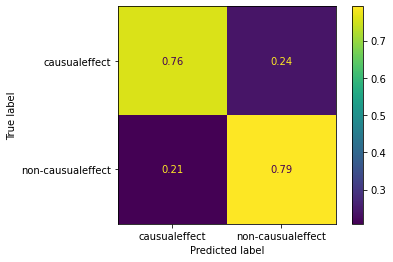

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=model_performance['confusion_matrix_normalized'],display_labels = list(id2label.values()))
disp.plot()

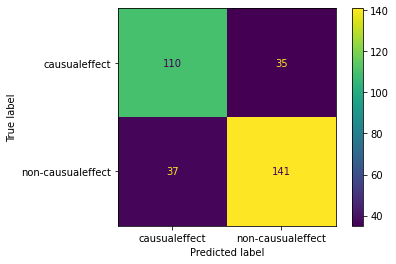

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=model_performance['confusion_matrix'],display_labels = list(id2label.values()))
disp.plot()